In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0, DenseNet201
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
import time
import psutil

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [3]:
labels = ['Early_Blight','Healthy','Late_Blight']

In [4]:
X_train = []
y_train = []
X_test = []
y_test = []
image_size = 128
for i in labels:
    folderPath = os.path.join('/kaggle/input/balanced-data/balanced_data','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('/kaggle/input/balanced-data/balanced_data','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_test.append(img)
        y_test.append(i)
        
for i in labels:
    folderPath = os.path.join('/kaggle/input/balanced-data/balanced_data','Validation',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

100%|██████████| 163/163 [00:02<00:00, 70.55it/s]


In [5]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4398, 128, 128, 3)
(4398,)
(486, 128, 128, 3)
(486,)


In [6]:
# Reshape X_train
nsamples, nx, ny, nrgb = X_train.shape
X_train = X_train.reshape((nsamples,nx*ny*nrgb))

# Reshape X_test
nsamples, nx, ny, nrgb= X_test.shape
X_test = X_test.reshape(nsamples, nx*ny*nrgb)

In [7]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4398, 49152)
(4398,)
(486, 49152)
(486,)


In [8]:
all_model = pd.DataFrame(columns=['Model', 'Accuracy (Train)', 'Precision (Train)', 'Recall (Train)', 'F1 Score (Train)', 'Accuracy (Test)', 'Precision (Test)', 'Recall (Test)', 'F1 Score (Test)', 'Training Time (s)', 'Testing Time (s)','Memory (MB)'])

In [9]:
all_model

,Model,Accuracy (Train),Precision (Train),Recall (Train),F1 Score (Train),Accuracy (Test),Precision (Test),Recall (Test),F1 Score (Test),Training Time (s),Testing Time (s),Memory (MB)


**Machine Learning**

In [10]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)

In [11]:
y_train

array([0, 0, 0, ..., 2, 2, 2])

In [12]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_test = le.fit_transform(y_test)

In [13]:
y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

**XGBoost**

In [14]:
from xgboost import XGBClassifier

# define the XGB model
xgb = XGBClassifier(
    n_estimators=300,            
    learning_rate=0.05,          
    max_depth=6,                 
    objective='multi:softprob',  
    num_class=3,                
    subsample=0.8,               
    colsample_bytree=0.8,        
    gamma=1,                     
    min_child_weight=3,          
    random_state=42              
)

# fit the model on the training data
start_time = time.time()
xgb.fit(X_train, y_train)
training_time = time.time() - start_time
memory_usage = psutil.Process().memory_info().rss / 1024 / 1024

In [15]:
# make predictions on the test data
start_time = time.time()
y_pred = xgb.predict(X_test)
testing_time = time.time() - start_time

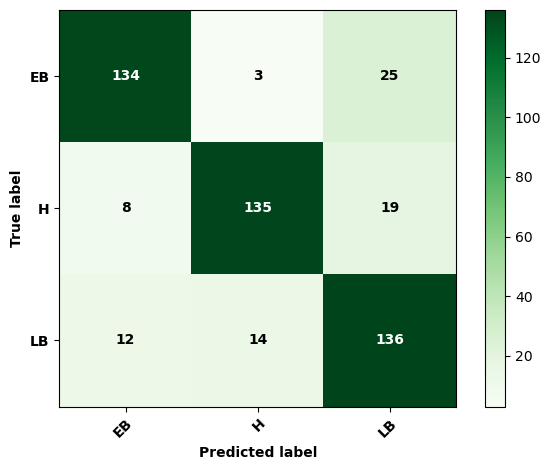

In [16]:
classes=['EB','H','LB']
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes,
       yticklabels=classes,
       xlabel='Predicted label',
       ylabel='True label',
       aspect='equal',
       )
plt.xticks(np.arange(cm.shape[1]),  rotation=45, fontweight='bold', color='black',fontsize=10)
plt.yticks(np.arange(cm.shape[0]),  fontweight='bold', color='black',fontsize=10)
plt.ylabel('True label', fontweight='bold', color='black',fontsize=10)
plt.xlabel('Predicted label', fontweight='bold', color='black',fontsize=10)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center", fontweight='bold',
                color="white" if cm[i, j] > cm.max() / 2. else "black")
fig.tight_layout()
plt.show()

In [17]:
accuracy_test = accuracy_score(y_test, y_pred)*100
precision_test = precision_score(y_test, y_pred, average='macro')*100
recall_test = recall_score(y_test, y_pred, average='macro')*100
f1_test = f1_score(y_test, y_pred, average='macro')*100

print("Accuracy (Test): {:.4f}".format(accuracy_test))
print("Precision (Test): {:.4f}".format(precision_test))
print("Recall (Test): {:.4f}".format(recall_test))
print("F1 score (Test): {:.4f}".format(f1_test))

Accuracy (Test): 83.3333
Precision (Test): 83.7948
Recall (Test): 83.3333
F1 score (Test): 83.4432


In [18]:
# make predictions on the train data
y_pred = xgb.predict(X_train)

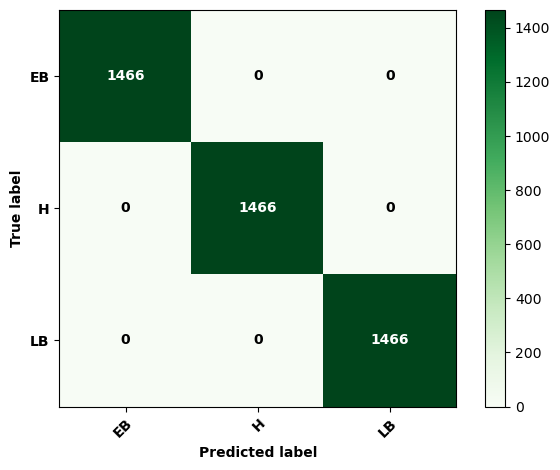

In [19]:
classes=['EB','H','LB']
# Compute the confusion matrix
cm = confusion_matrix(y_train, y_pred)

# Plot the confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes,
       yticklabels=classes,
       xlabel='Predicted label',
       ylabel='True label',
       aspect='equal',
       )
plt.xticks(np.arange(cm.shape[1]),  rotation=45, fontweight='bold', color='black',fontsize=10)
plt.yticks(np.arange(cm.shape[0]),  fontweight='bold', color='black',fontsize=10)
plt.ylabel('True label', fontweight='bold', color='black',fontsize=10)
plt.xlabel('Predicted label', fontweight='bold', color='black',fontsize=10)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center", fontweight='bold',
                color="white" if cm[i, j] > cm.max() / 2. else "black")
fig.tight_layout()
plt.show()

In [20]:
accuracy_train = accuracy_score(y_train, y_pred)*100
precision_train = precision_score(y_train, y_pred, average='macro')*100
recall_train = recall_score(y_train, y_pred, average='macro')*100
f1_train = f1_score(y_train, y_pred, average='macro')*100

print("Accuracy (Train): {:.4f}".format(accuracy_train))
print("Precision (Train): {:.4f}".format(precision_train))
print("Recall (Train): {:.4f}".format(recall_train))
print("F1 score (Train): {:.4f}".format(f1_train))

Accuracy (Train): 100.0000
Precision (Train): 100.0000
Recall (Train): 100.0000
F1 score (Train): 100.0000


In [21]:
model_name='XGB'
all_model.loc[len(all_model)] = [model_name, accuracy_train, precision_train, recall_train, f1_train, accuracy_test, precision_test, recall_test, f1_test, training_time, testing_time, memory_usage]

In [22]:
all_model

,Model,Accuracy (Train),Precision (Train),Recall (Train),F1 Score (Train),Accuracy (Test),Precision (Test),Recall (Test),F1 Score (Test),Training Time (s),Testing Time (s),Memory (MB)
0,XGB,100.0,100.0,100.0,100.0,83.333333,83.794777,83.333333,83.443184,5009.10393,0.147002,1081.632812
